In [ ]:
#Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

#Use SQLAlchemy create_engine to connect to your sqlite database.

#Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.


In [84]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, inspect, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
Base = declarative_base()
import pandas as pd
from warnings import filterwarnings
import pymysql
filterwarnings('ignore', category=pymysql.Warning)
import os
from dateutil import parser
from datetime import datetime 
import datetime as dt
import time
import dateutil
import argparse
import numpy as np

import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [74]:
engine = create_engine("sqlite:///new_database.sqlite")

In [75]:
Base = automap_base()

In [76]:
Base.prepare(engine, reflect=True)

In [77]:
Base.classes.keys()

['measurements', 'stations']

In [78]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [79]:
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [80]:
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
date DATE
prcp FLOAT
tobs INTEGER


In [81]:
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation INTEGER


In [82]:
session = Session(engine)

In [85]:
#Precipitation Analysis
#Design a query to retrieve the last 12 months of precipitation data.
#Select only the date and prcp values.
results = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date > dt.date(2016, 8, 23))

In [86]:
#Load the query results into a Pandas DataFrame and set the index to the date column.
df = pd.DataFrame(results[:], columns=['date', 'prcp'])
df.set_index('date', inplace=True, )
df.count()

prcp    2015
dtype: int64

In [87]:
#df.to_csv("test.csv", index=False, header=True)

In [88]:
clean_prcp_df = df.dropna()
clean_prcp_df.count()

prcp    2015
dtype: int64

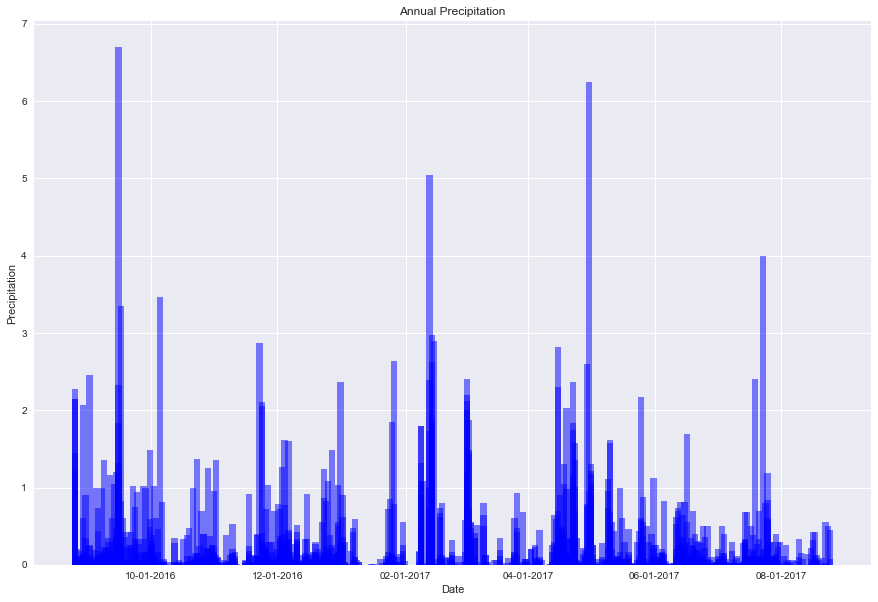

In [89]:
#Plot the results using the DataFrame plot method.

fix, ax = plt.subplots(figsize=(15, 10))

ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d-%Y'))

ax.bar(clean_prcp_df.index, clean_prcp_df['prcp'], color='b', alpha=0.5, width=3, align="edge")

plt.title("Annual Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.show()
plt.gcf().clear()


In [90]:
#Use Pandas to print the summary statistics for the precipitation data.
clean_prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [91]:
#Station Analysis
#Design a query to calculate the total number of stations.
results = session.query(Stations).count()
print(results)

9


In [92]:
#Design a query to find the most active stations.
#List the stations and observation counts in descending order
#Which station has the highest number of observations?

active_stations = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).statement
#print(active_stations)
df2 = pd.read_sql_query(active_stations, session.bind)
df2

,station,count_1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [94]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
#Filter by the station with the highest number of observations.

most_obs = session.query(Measurements.station, func.count(Measurements.tobs)).\
filter(Measurements.date > dt.date(2016, 8, 23)).\
group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).first()

most_obs

('USC00519397', 360)

In [95]:
data = session.query(Measurements.station, Measurements.tobs).\
filter(Measurements.date > dt.date(2016, 8, 23)).\
filter(Measurements.station == most_obs[0]).statement

df3 = pd.read_sql_query(data, session.bind)
df3.head()


,station,tobs
0,USC00519397,79
1,USC00519397,80
2,USC00519397,79
3,USC00519397,77
4,USC00519397,78


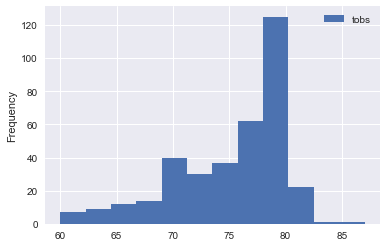

In [96]:
%matplotlib inline
df3.plot.hist(by="station", bins=12)

In [97]:
#Temperature Analysis
#Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and 
#return the minimum, average, and maximum temperatures for that range of dates.

#Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the 
#matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

def valid_date(date):
    try:
        return datetime.strptime(date, "%Y-%m-%d")
    except ValueError:
        msg = "Not a valid date: " + date
        raise argparse.ArgumentTypeError(msg)

def calc_temps(start_date, end_date):
    start_date = valid_date(start_date)
    end_date = valid_date(end_date)

    temps = session.query(Measurements.tobs).\
    filter(Measurements.date >= start_date).\
    filter(Measurements.date <= end_date)

    df4 = pd.read_sql_query(temps.statement, temps.session.bind)
    return df4.describe()

temp_data = calc_temps('2017-05-15', '2017-05-31')
temp_data



,tobs
count,90.000000
mean,75.077778
std,3.648080
min,68.000000
25%,72.000000
50%,75.000000
75%,78.000000
max,87.000000


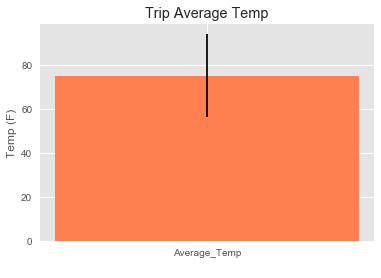

In [98]:
#Plot the min, avg, and max temperature from your previous query as a bar chart.
#Use the average temperature as the bar height.
#Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

plt.style.use('ggplot')
x = ['Average_Temp']
mean = temp_data['tobs']['mean']
variance= (temp_data['tobs']['max'])-(temp_data['tobs']['min'])

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, mean, color='coral', yerr=variance)


plt.ylabel('Temp (F)')
plt.xlabel(' ')
plt.title('Trip Average Temp')


plt.xticks(x_pos, x)
plt.figure(figsize=(20,2))
plt.show()

